In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import random

In [ ]:
random.seed(760)

In [ ]:
data=pd.read_csv('drive/MyDrive/clean_data.csv', encoding='utf-8')
def get_season(month): #春0夏1秋2冬3
    if 9 <= month <= 11:
        return "0"
    elif 12 <= month <= 2:
        return "1"
    elif 3 <= month <= 6:
        return "2"
    else:
        return "3"
data['Date'] = pd.to_datetime(data['Date'])
data['season'] = data['Date'].dt.month.apply(get_season)
grouped_data = data.groupby("Date")["Victimisations"].sum().reset_index()
grouped_data['season'] = data.groupby("Date")['season'].first().reset_index()['season']

In [ ]:
train_data = grouped_data[grouped_data['Date'] < '2021-01-01']
test_data = grouped_data[grouped_data['Date'] >= '2021-01-01']


In [ ]:
scaler = MinMaxScaler()
grouped_data_scaled = scaler.fit_transform(grouped_data[['Victimisations', 'season']])
train_data_scaled = grouped_data_scaled[grouped_data['Date'] < '2021-01-01']
test_data_scaled = grouped_data_scaled[grouped_data['Date'] >= '2021-01-01']

In [ ]:
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), :])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

window_size = 3
X_train, y_train = create_dataset(train_data_scaled, window_size)
X_test, y_test = create_dataset(test_data_scaled, window_size)

In [ ]:
model = Sequential()
model.add(LSTM(150,return_sequences=True,input_shape=(window_size, 2)))
model.add(LSTM(100))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=20)
history = model.fit(X_train, y_train, epochs=200, batch_size=4,validation_split=0.15,callbacks=[early_stop])

Epoch 1/200
14/14 [==============================] - 14s 230ms/step - loss: 0.0830 - val_loss: 0.1495
Epoch 2/200
14/14 [==============================] - 0s 19ms/step - loss: 0.0272 - val_loss: 0.0465
Epoch 3/200
14/14 [==============================] - 0s 23ms/step - loss: 0.0122 - val_loss: 0.0652
Epoch 4/200
14/14 [==============================] - 0s 23ms/step - loss: 0.0067 - val_loss: 0.0456
Epoch 5/200
14/14 [==============================] - 0s 25ms/step - loss: 0.0046 - val_loss: 0.0527
Epoch 6/200
14/14 [==============================] - 0s 20ms/step - loss: 0.0036 - val_loss: 0.0513
Epoch 7/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0037 - val_loss: 0.0491
Epoch 8/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0037 - val_loss: 0.0543
Epoch 9/200
14/14 [==============================] - 0s 13ms/step - loss: 0.0040 - val_loss: 0.0475
Epoch 10/200
14/14 [==============================] - 0s 17ms/step - loss: 0.0034 - val_loss: 0.04

In [ ]:
predicted = model.predict(X_test)
predicted_transformed = scaler.inverse_transform(np.concatenate([np.reshape(predicted, (-1, 1)), np.zeros((len(predicted), 1))], axis=1))[:, 0]
y_test_transformed = scaler.inverse_transform(np.concatenate([np.reshape(y_test, (-1, 1)), np.zeros((len(y_test), 1))], axis=1))[:, 0]

1/1 [==============================] - 1s 812ms/step


In [ ]:
mse = mean_squared_error(y_test_transformed, predicted_transformed)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 4945607.089491372


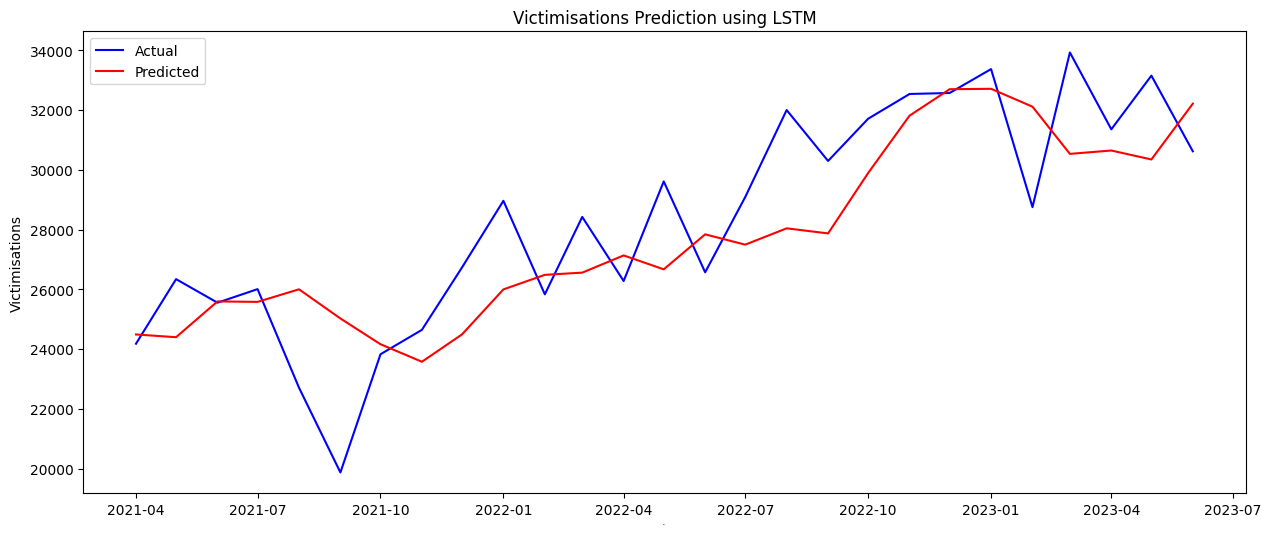

In [ ]:
time_axis = test_data['Date'][window_size:]
plt.figure(figsize=(15, 6))
plt.plot(time_axis, y_test_transformed, label='Actual', color='blue')
plt.plot(time_axis, predicted_transformed, label='Predicted', color='red')
plt.xlabel('Date', fontsize=0.1)
plt.ylabel('Victimisations')
plt.title('Victimisations Prediction using LSTM')
plt.legend()
plt.show()

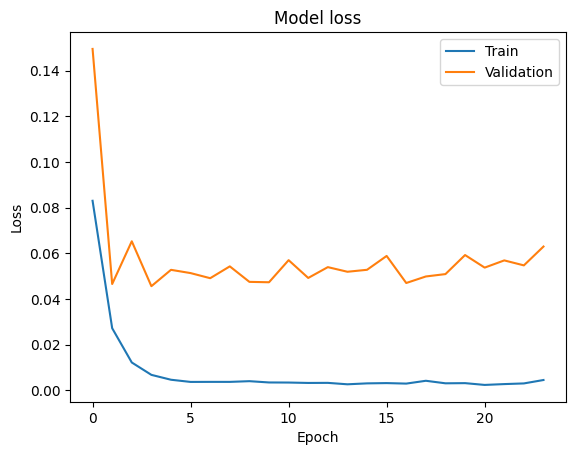

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

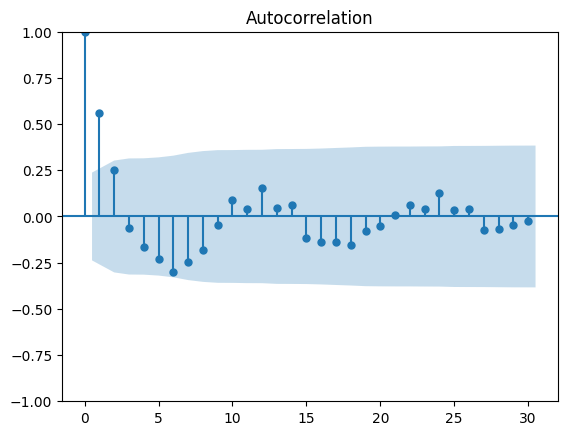

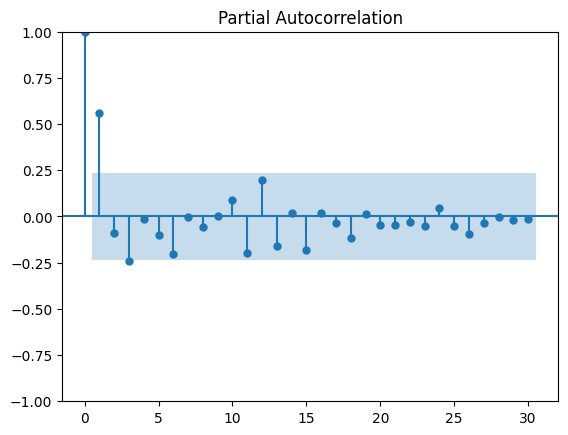

In [ ]:
plot_acf(train_data['Victimisations'],lags=30)
plt.show()
plot_pacf(train_data['Victimisations'],lags=30)
plt.show()

In [ ]:
model = SARIMAX(train_data['Victimisations'], order=(1,0,2), seasonal_order=(1,0,1,12))
model_fit = model.fit()
predictions_ARIMA = model_fit.forecast(steps=len(test_data))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


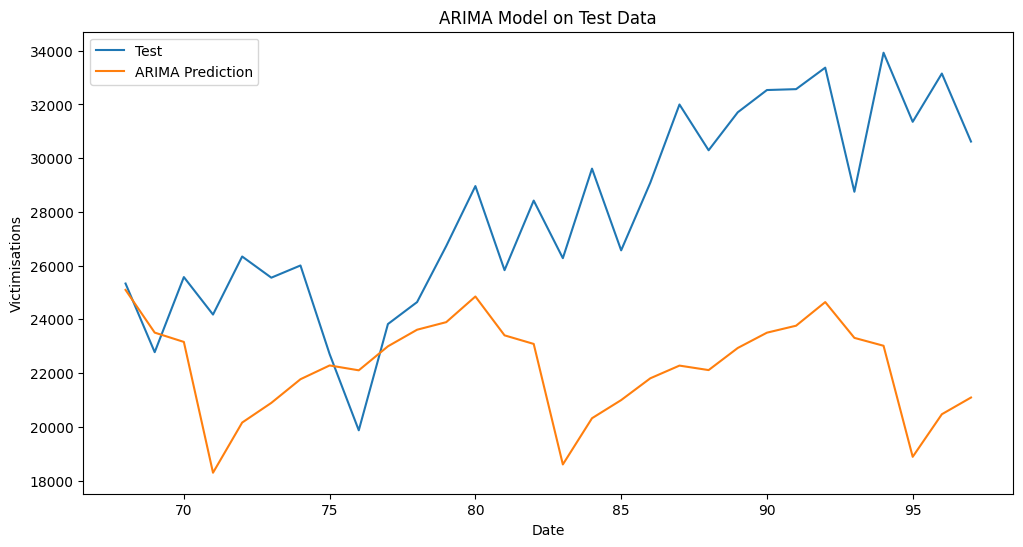

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Victimisations'], label='Test')
plt.plot(test_data.index, predictions_ARIMA, label='ARIMA Prediction')
plt.title("ARIMA Model on Test Data")
plt.xlabel("Date")
plt.ylabel("Victimisations")
plt.legend()
plt.show()

In [ ]:
residuals = train_data['Victimisations'] - model_fit.fittedvalues
residuals

0     21250.000000
1       -58.973137
2       296.767977
3        -1.242971
4      -580.971860
          ...     
63     -973.415513
64      114.095920
65     -174.149017
66      352.225807
67       51.809366
Length: 68, dtype: float64

In [ ]:
scaler = MinMaxScaler()
residuals_with_season = pd.DataFrame({'residuals': residuals, 'season': train_data['season']})
residuals_with_season_scaled = scaler.fit_transform(residuals_with_season)
window_size = 3
X_train_res, y_train_res = create_dataset(residuals_with_season_scaled, window_size)
model_res = Sequential()
model_res.add(LSTM(200, return_sequences=True, input_shape=(window_size, 2)))
model_res.add(LSTM(150))
model_res.add(Dropout(0.1))
model_res.add(Dense(1))
model_res.compile(optimizer='adam', loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=20)
history_res = model_res.fit(X_train_res, y_train_res, epochs=200, batch_size=4, validation_split=0.15, callbacks=[early_stop])



Epoch 1/200
14/14 [==============================] - 6s 92ms/step - loss: 0.0306 - val_loss: 0.0267
Epoch 2/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0082 - val_loss: 0.0141
Epoch 3/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0041 - val_loss: 0.0122
Epoch 4/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0026 - val_loss: 0.0131
Epoch 5/200
14/14 [==============================] - 0s 12ms/step - loss: 0.0022 - val_loss: 0.0101
Epoch 6/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0021 - val_loss: 0.0105
Epoch 7/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 0.0105
Epoch 8/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0017 - val_loss: 0.0126
Epoch 9/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0019 - val_loss: 0.0109
Epoch 10/200
14/14 [==============================] - 0s 11ms/step - loss: 0.0020 - val_loss: 0.0136

In [ ]:
predicted_res = model_res.predict(X_test)
zero_col = np.zeros((predicted_res.shape[0], 1))
predicted_res_with_zero_col = np.hstack([predicted_res, zero_col])
predicted_res_transformed = scaler.inverse_transform(predicted_res_with_zero_col)
predicted_res_transformed_1D = predicted_res_transformed[:, 0]
min_length = min(len(predictions_ARIMA), len(predicted_res_transformed_1D))
predicted_res_transformed = -predicted_res_transformed
final_prediction = predictions_ARIMA[:min_length] + predicted_res_transformed_1D[:min_length]


1/1 [==============================] - 1s 900ms/step


In [ ]:
mse2 = mean_squared_error(y_test_transformed, final_prediction)
print(f'Mean Squared Error: {mse2}')

Mean Squared Error: 15895778.398724364


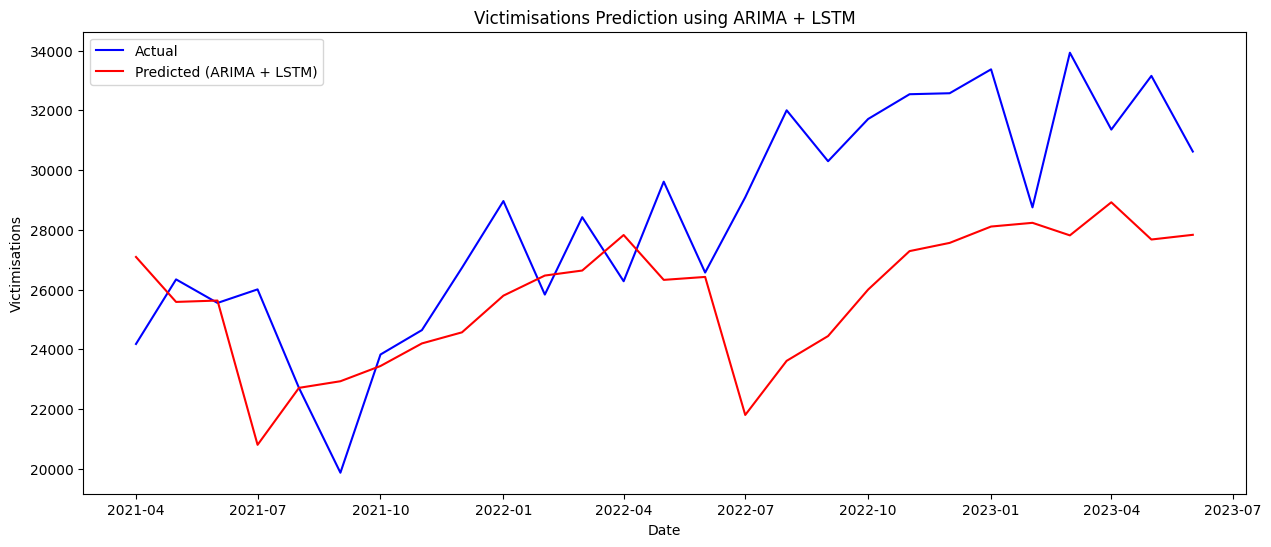

In [ ]:
min_length = min(len(time_axis), len(final_prediction))
time_axis = time_axis[:min_length]
final_prediction = final_prediction[:min_length]
plt.figure(figsize=(15, 6))
plt.plot(time_axis, y_test_transformed[:min_length], label='Actual', color='blue')
plt.plot(time_axis, final_prediction, label='Predicted (ARIMA + LSTM)', color='red')
plt.xlabel('Date')
plt.ylabel('Victimisations')
plt.title('Victimisations Prediction using ARIMA + LSTM')
plt.legend()
plt.show()


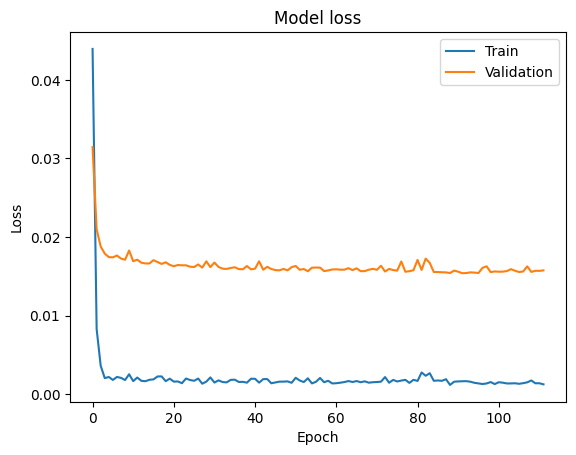

In [ ]:
plt.plot(history_res.history['loss'])
plt.plot(history_res.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
selected_age = ['Teenagers', 'Middle-aged-young', 'Middle-aged-old', 'Elderly']
filtered_data = data[data['Age Group'].isin(selected_age)]
crime_counts_by_age = filtered_data.groupby(['Date', 'Age Group'])['Victimisations'].sum().reset_index()

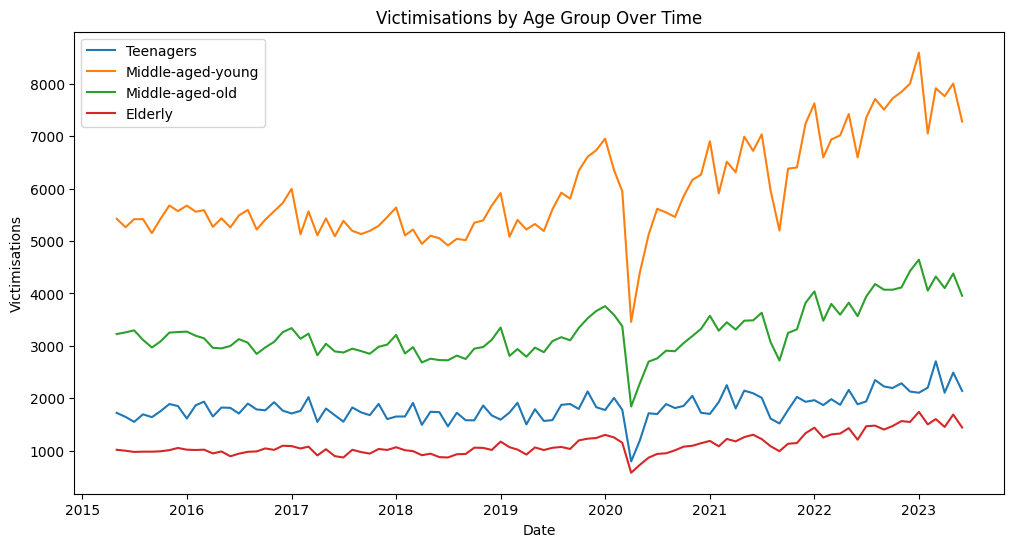

In [ ]:
crime_counts_by_age['Date'] = pd.to_datetime(crime_counts_by_age['Date'])
crime_counts_by_age.sort_values(['Date', 'Age Group'], inplace=True)
plt.figure(figsize=(12, 6))
for age_group in selected_age:
    subset = crime_counts_by_age[crime_counts_by_age['Age Group'] == age_group]
    plt.plot(subset['Date'], subset['Victimisations'], label=age_group)

plt.xlabel('Date')
plt.ylabel('Victimisations')
plt.title('Victimisations by Age Group Over Time')
plt.legend()
plt.show()

In [ ]:
selected_ethnicities = ['Asian', 'European', 'Indian', 'Maori', 'Pacific Island']
filtered_data = data[data['Ethnic Group'].isin(selected_ethnicities)]
crime_counts_by_ethnicity = filtered_data.groupby(['Date', 'Ethnic Group'])['Victimisations'].sum().reset_index()
crime_counts_by_ethnicity


,Date,Ethnic Group,Victimisations
0,2015-05-01,Asian,578
1,2015-05-01,European,4758
2,2015-05-01,Indian,548
3,2015-05-01,Maori,1953
4,2015-05-01,Pacific Island,562
...,...,...,...
485,2023-06-01,Asian,525
486,2023-06-01,European,4549
487,2023-06-01,Indian,664
488,2023-06-01,Maori,3093


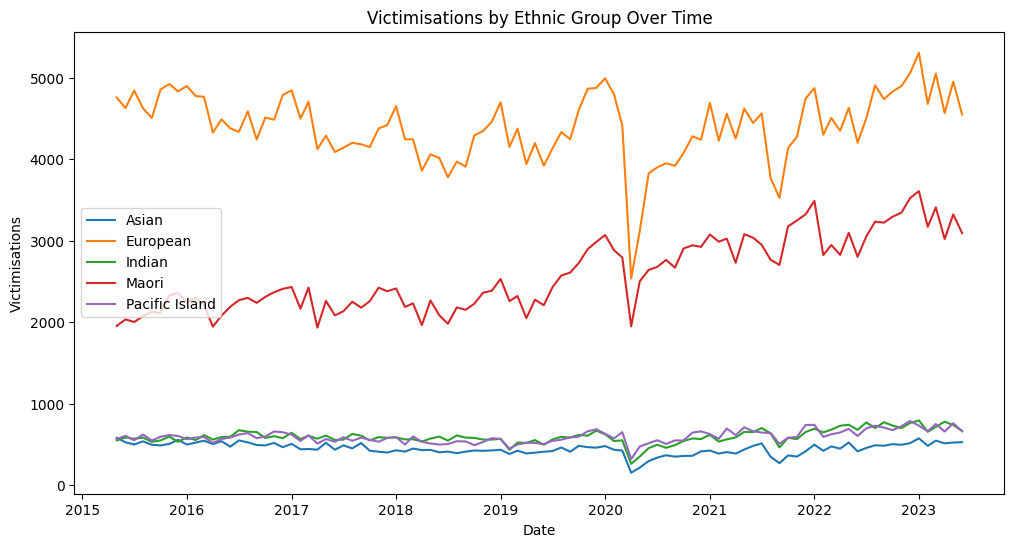

In [ ]:
crime_counts_by_ethnicity['Date'] = pd.to_datetime(crime_counts_by_ethnicity['Date'])
crime_counts_by_ethnicity.sort_values(['Date', 'Ethnic Group'], inplace=True)
plt.figure(figsize=(12, 6))
for ethnicity in selected_ethnicities:
    subset = crime_counts_by_ethnicity[crime_counts_by_ethnicity['Ethnic Group'] == ethnicity]
    plt.plot(subset['Date'], subset['Victimisations'], label=ethnicity)

plt.xlabel('Date')
plt.ylabel('Victimisations')
plt.title('Victimisations by Ethnic Group Over Time')
plt.legend()
plt.show()


Epoch 1/200
14/14 [==============================] - 7s 62ms/step - loss: 0.2646 - val_loss: 0.1061
Epoch 2/200
14/14 [==============================] - 0s 8ms/step - loss: 0.0312 - val_loss: 0.0953
Epoch 3/200
14/14 [==============================] - 0s 10ms/step - loss: 0.0203 - val_loss: 0.1015
Epoch 4/200
14/14 [==============================] - 0s 10ms/step - loss: 0.0121 - val_loss: 0.0984
Epoch 5/200
14/14 [==============================] - 0s 8ms/step - loss: 0.0101 - val_loss: 0.0954
Epoch 6/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0109 - val_loss: 0.0971
Epoch 7/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0120 - val_loss: 0.0960
Epoch 8/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0106 - val_loss: 0.1004
Epoch 9/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0121 - val_loss: 0.0943
Epoch 10/200
14/14 [==============================] - 0s 8ms/step - loss: 0.0120 - val_loss: 0.0960
Epoch 

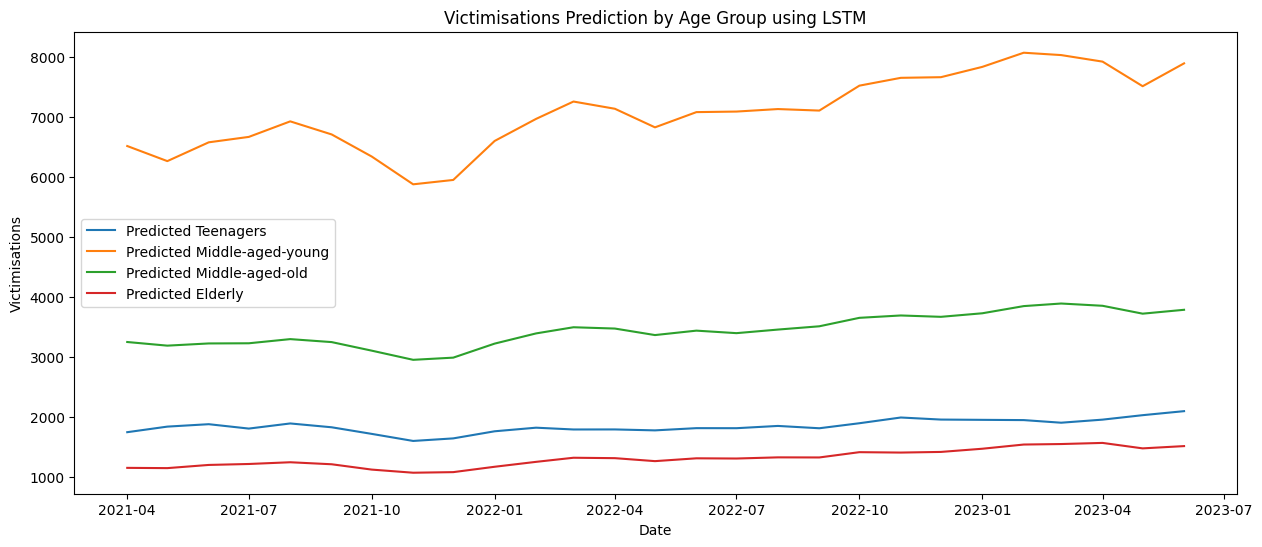

In [ ]:
from keras.callbacks import EarlyStopping

# LSTM模型训练和预测的函数
def train_and_predict_LSTM(X_train, y_train, X_test):
    model = Sequential()
    model.add(LSTM(150, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # 加入早停回调
    early_stop = EarlyStopping(monitor='val_loss', patience=20)

    model.fit(X_train[:, :, np.newaxis], y_train, epochs=200, batch_size=4, validation_split=0.15, callbacks=[early_stop])
    predicted = model.predict(X_test[:, :, np.newaxis])
    return predicted

plt.figure(figsize=(15, 6))

# 对每一个年龄组进行训练和预测
for age_group in selected_age:
    age_data = crime_counts_by_age[crime_counts_by_age['Age Group'] == age_group]
    age_data = age_data.sort_values('Date')

    train_data = age_data[age_data['Date'] < '2021-01-01']['Victimisations'].values
    test_data = age_data[age_data['Date'] >= '2021-01-01']['Victimisations'].values

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.reshape(-1, 1))

    X_train, y_train = create_dataset(train_scaled, window_size)
    X_test, _ = create_dataset(test_scaled, window_size)  # 这里的"_"表示我们不用这个返回值

    predicted_scaled = train_and_predict_LSTM(X_train, y_train, X_test)
    predicted = scaler.inverse_transform(predicted_scaled)

    # 为预测结果创建一个时间轴
    time_axis = age_data['Date'][age_data['Date'] >= '2021-01-01'][window_size:]

    plt.plot(time_axis, predicted, label=f'Predicted {age_group}')

# 绘制图形
plt.xlabel('Date')
plt.ylabel('Victimisations')
plt.title('Victimisations Prediction by Age Group using LSTM')
plt.legend()
plt.show()


Epoch 1/200
14/14 [==============================] - 4s 62ms/step - loss: 0.2619 - val_loss: 0.0738
Epoch 2/200
14/14 [==============================] - 0s 8ms/step - loss: 0.0250 - val_loss: 0.0616
Epoch 3/200
14/14 [==============================] - 0s 8ms/step - loss: 0.0093 - val_loss: 0.0858
Epoch 4/200
14/14 [==============================] - 0s 8ms/step - loss: 0.0070 - val_loss: 0.0675
Epoch 5/200
14/14 [==============================] - 0s 8ms/step - loss: 0.0088 - val_loss: 0.0830
Epoch 6/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0080 - val_loss: 0.0650
Epoch 7/200
14/14 [==============================] - 0s 8ms/step - loss: 0.0086 - val_loss: 0.0924
Epoch 8/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0065 - val_loss: 0.0658
Epoch 9/200
14/14 [==============================] - 0s 9ms/step - loss: 0.0057 - val_loss: 0.0741
Epoch 10/200
14/14 [==============================] - 0s 8ms/step - loss: 0.0060 - val_loss: 0.0716
Epoch 11

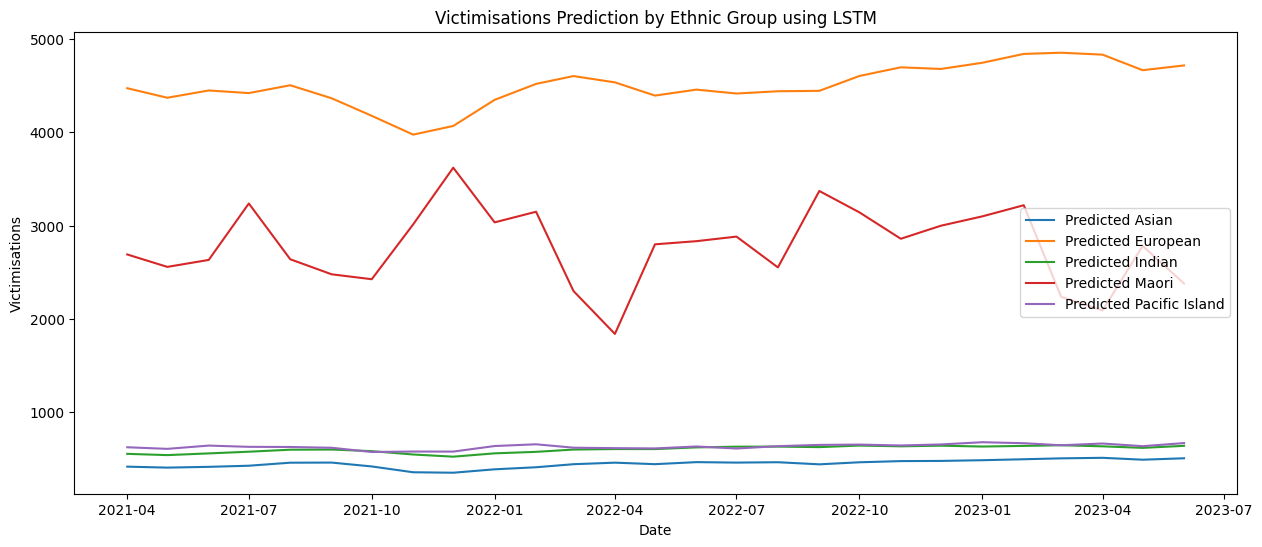

In [ ]:
plt.figure(figsize=(15, 6))
def train_and_predict_LSTM(X_train, y_train, X_test):
    model = Sequential()
    model.add(LSTM(150, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # 加入早停回调
    early_stop = EarlyStopping(monitor='val_loss', patience=20)

    model.fit(X_train[:, :, np.newaxis], y_train, epochs=200, batch_size=4, validation_split=0.15, callbacks=[early_stop])
    predicted = model.predict(X_test[:, :, np.newaxis])
    return predicted
for ethnicity in selected_ethnicities:
    ethnic_data = crime_counts_by_ethnicity[crime_counts_by_ethnicity['Ethnic Group'] == ethnicity]
    ethnic_data = ethnic_data.sort_values('Date')

    train_data = ethnic_data[ethnic_data['Date'] < '2021-01-01']['Victimisations'].values
    test_data = ethnic_data[ethnic_data['Date'] >= '2021-01-01']['Victimisations'].values

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
    test_scaled = scaler.transform(test_data.reshape(-1, 1))

    X_train, y_train = create_dataset(train_scaled, window_size)
    X_test, _ = create_dataset(test_scaled, window_size)

    predicted_scaled = train_and_predict_LSTM(X_train, y_train, X_test)
    predicted = scaler.inverse_transform(predicted_scaled)

    # 为预测结果创建一个时间轴
    time_axis = ethnic_data['Date'][ethnic_data['Date'] >= '2021-01-01'][window_size:]

    plt.plot(time_axis, predicted, label=f'Predicted {ethnicity}')

# 绘制图形
plt.xlabel('Date')
plt.ylabel('Victimisations')
plt.title('Victimisations Prediction by Ethnic Group using LSTM')
plt.legend()
plt.show()